In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import os

from autoreject import AutoReject

In [16]:
mne.set_log_level('error') 

In [2]:
data_dir = "Processed"
p_num = 5

In [3]:
raw = mne.io.read_raw_fif(f"{data_dir}/P{p_num}/P{p_num}-filt-raw.fif", preload=True)
montage = "standard_1020"
raw.set_montage(montage)  

Opening raw data file Processed/P5/P5-filt-raw.fif...


    Range : 0 ... 525841 =      0.000 ...  2103.364 secs
Ready.
Reading 0 ... 525841  =      0.000 ...  2103.364 secs...


<Raw | P5-filt-raw.fif, 8 x 525842 (2103.4 s), ~32.1 MiB, data loaded>

In [4]:
loaded_events = mne.read_events(f"{data_dir}/P{p_num}/P{p_num}_eve.fif")

In [5]:
unique_events, counts = np.unique(loaded_events[:, 2], return_counts=True)

In [6]:
event_id = {}
if 1 in unique_events:
    event_id['TP'] = 1
if 2 in unique_events:
    event_id['FN'] = 2
if 3 in unique_events:
    event_id['FP'] = 3
if 4 in unique_events:
    event_id['TN'] = 4
if 5 in unique_events:
    event_id['Polygon'] = 5
event_id

{'TP': 1, 'TN': 4, 'Polygon': 5}

In [7]:
epochs = mne.Epochs(
    raw=raw,
    events=loaded_events,
    event_id=event_id,
    tmin=-0.2,  # Time before event (in seconds)
    tmax=0.5,   # Time after event (in seconds)
    baseline=(None, 0),  # Baseline correction period
    picks=None,  # All channels
    preload=True  # Load data into memory
)

Not setting metadata
163 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 163 events and 176 original time points ...
0 bad epochs dropped


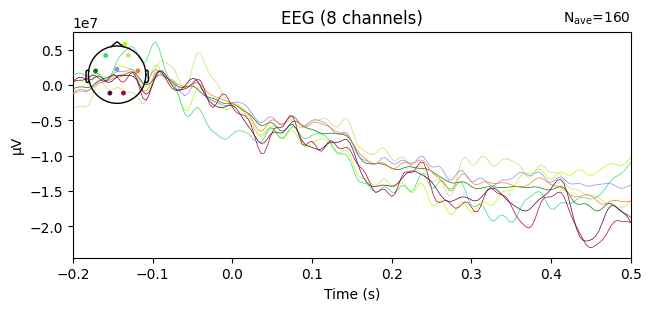

In [8]:
epochs['TP', 'TN'].average().plot();

In [9]:
ica = mne.preprocessing.read_ica(f"{data_dir}/P{p_num}/P{p_num}-ica.fif")

# apply the ICA decomposition (excluding the marked ICs) to the epochs
epochs_postica = ica.apply(epochs.copy())

Reading /mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/P5/P5-ica.fif ...


Now restoring ICA solution ...
Ready.
Applying ICA to Epochs instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


/tmp/ipykernel_110143/3397977182.py:4: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_postica = ica.apply(epochs.copy())


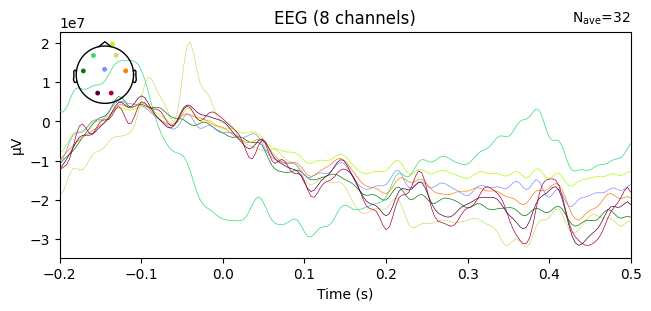

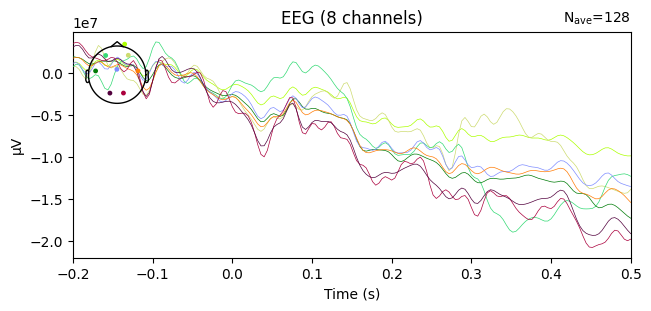

In [10]:
epochs_postica['TP'].average().plot();
epochs_postica['TN'].average().plot();

In [ ]:
participants = range(1, 6)  # For participants 1-5

# Empty lists to store all epochs and events
all_epochs = []
all_events = []

for p_num in participants:
    print(f"Processing participant {p_num}...")
    
    # File paths
    raw_file = f"{data_dir}/P{p_num}/P{p_num}-filt-raw.fif"
    events_file = f"{data_dir}/P{p_num}/P{p_num}_eve.fif"
    ica_file = f"{data_dir}/P{p_num}/P{p_num}-ica.fif"
    
    # Skip if files don't exist
    if not os.path.exists(raw_file) or not os.path.exists(events_file) or not os.path.exists(ica_file):
        print(f"Files for participant {p_num} not found. Skipping.")
        continue
    
    # Load raw data
    raw = mne.io.read_raw_fif(raw_file, preload=True)
    
    # Load events
    events = mne.read_events(events_file)
    
    # Check which event types exist for this participant
    unique_events = np.unique(events[:, 2])
    
    # Create event_id dictionary based on available events
    event_id = {}
    if 1 in unique_events: event_id['TP'] = 1
    if 2 in unique_events: event_id['FN'] = 2
    if 3 in unique_events: event_id['FP'] = 3
    if 4 in unique_events: event_id['TN'] = 4
    if 5 in unique_events: event_id['Polygon'] = 5
    
    try:
        # Create epochs for this participant
        epochs = mne.Epochs(
            raw=raw,
            events=events,
            event_id=event_id,
            tmin=-0.5,
            tmax=3,
            baseline=(None, 0),
            picks=None,
            preload=True
        )
        
        # Apply ICA correction
        ica = mne.preprocessing.read_ica(ica_file)
        epochs_clean = ica.apply(epochs.copy())  # Apply ICA
        
        # Add participant information to metadata
        if not hasattr(epochs_clean, 'metadata') or epochs_clean.metadata is None:
            from pandas import DataFrame
            epochs_clean.metadata = DataFrame({'participant': [p_num] * len(epochs_clean)})
        else:
            epochs_clean.metadata['participant'] = p_num
        
        # Append the ICA-corrected epochs to our list
        all_epochs.append(epochs_clean)
        all_events.append(events)
        
        print(f"Successfully processed participant {p_num} - {len(epochs_clean)} epochs")
        
    except Exception as e:
        print(f"Error processing participant {p_num}: {e}")

# Combine epochs from all participants
if all_epochs:
    combined_epochs = mne.concatenate_epochs(all_epochs)
    print("\nCombined epochs information:")
    print(combined_epochs)
    
    # Print event type counts
    for event_name, event_code in combined_epochs.event_id.items():
        count = len(combined_epochs[event_name])
        print(f"Event type '{event_name}' (code {event_code}): {count} epochs")
else:
    print("No valid epochs were created.")

Processing participant 1...
Successfully processed participant 1 - 211 epochs
Processing participant 2...
Successfully processed participant 2 - 247 epochs
Processing participant 3...
Successfully processed participant 3 - 143 epochs
Processing participant 4...
Successfully processed participant 4 - 163 epochs
Processing participant 5...
Successfully processed participant 5 - 163 epochs

Combined epochs information:
<EpochsArray | 927 events (all good), -0.5 – 3 s (baseline -0.5 – 0 s), ~49.6 MiB, data loaded, with metadata,
 'TP': 144
 'TN': 683
 'Polygon': 12
 'FN': 43
 'FP': 45>
Event type 'TP' (code 1): 144 epochs
Event type 'TN' (code 4): 683 epochs
Event type 'Polygon' (code 5): 12 epochs
Event type 'FN' (code 2): 43 epochs
Event type 'FP' (code 3): 45 epochs


In [18]:


ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(combined_epochs.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

epochs_clean, reject_log_clean = ar.fit_transform(combined_epochs, return_log=True)

epochs_clean

<EpochsArray | 533 events (all good), -0.5 – 3 s (baseline -0.5 – 0 s), ~28.5 MiB, data loaded, with metadata,
 'TP': 72
 'TN': 382
 'Polygon': 0
 'FN': 37
 'FP': 42>

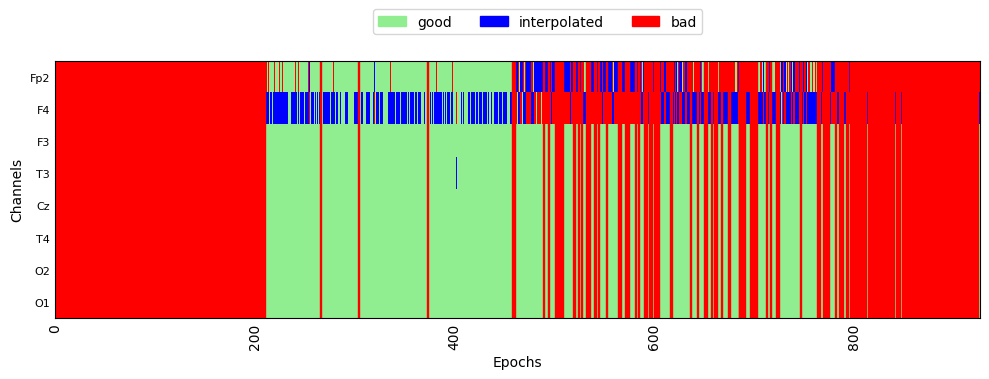

In [19]:
fig, ax = plt.subplots(figsize=[10, 4])
reject_log_clean.plot('horizontal', aspect='auto', ax=ax)
plt.show()

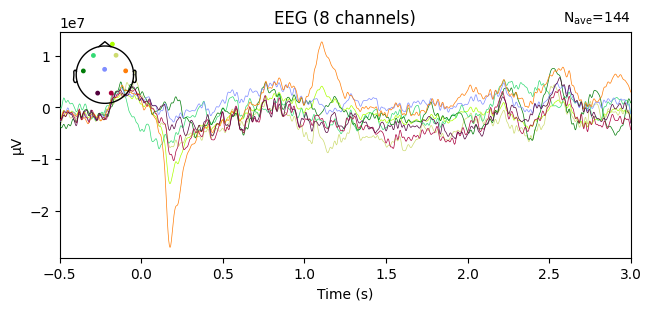

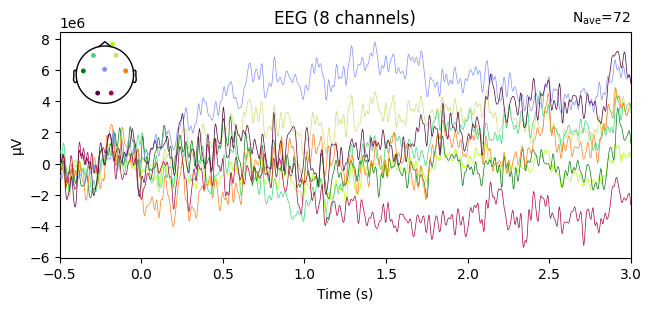

In [20]:
combined_epochs['TP'].average().plot();
epochs_clean['TP'].average().plot();

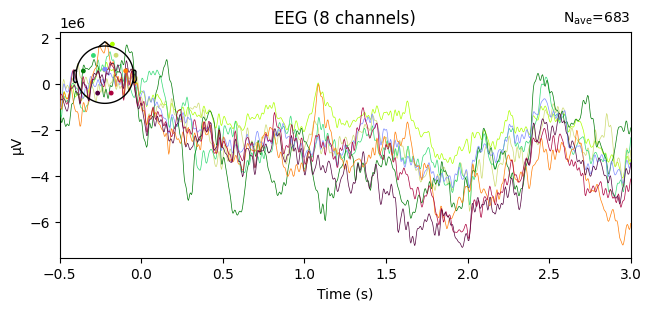

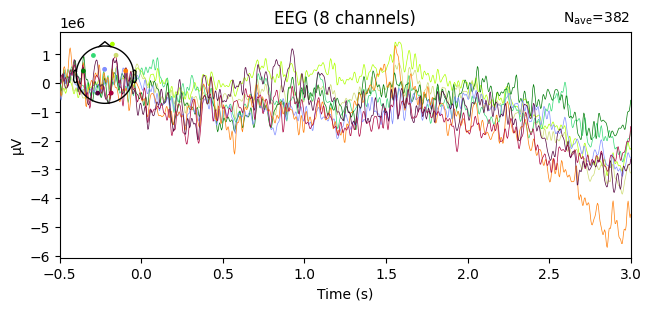

In [21]:
combined_epochs['TN'].average().plot();
epochs_clean['TN'].average().plot();

In [24]:
combined_epochs.save(f"{data_dir}/epo.fif", overwrite=True)

[PosixPath('/mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/epo.fif')]

In [25]:
epochs_clean.save(f"{data_dir}/clean-epo.fif", overwrite=True)

[PosixPath('/mnt/c/Users/Diego/OneDrive/Documents/Coding/Neurotech/DataAnalysis/Processed/clean-epo.fif')]